In [1]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA, FastICA,  IncrementalPCA, NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from glob import glob
import json
import os
import random
from keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import explained_variance_score

from matplotlib.pyplot import imread
import cv2
import random

In [2]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 100:
        files = random.sample(files, 100)
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img("crop_part1/"+file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Cluster{cluster}')

In [3]:
def update_dataframe_with_clusters(cluster):
    df_info['cluster'] = 0
    for key in cluster:
        df_info.loc[df_info.FileName.isin(cluster[key]), 'cluster'] = key

In [4]:
images = os.listdir("crop_part1")
images=images[1:]

In [5]:
data = {}
for image in images:
    data[image] = np.array(load_img("crop_part1/" + image, grayscale=True)).flatten().reshape(1,40000)

C:\Users\bgran\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
keys = np.array(list(data.keys()))
feats = np.array(list(data.values()))

In [7]:
nsamples, nx, ny = feats.shape
feats = feats.reshape((nsamples,nx*ny))

In [8]:
# global centering
faces_centered = feats - feats.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(len(images), -1)

In [9]:
n_components = 70
pca = PCA(n_components=30)
transformed_images=pca.fit_transform(faces_centered)

In [10]:
print(f"Components before PCA: {len(feats[0])}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 40000
Components after PCA: 30


In [11]:
variance_explained = np.cumsum(pca.explained_variance_ratio_)
print(f'The first {n_components} principal componenets explain {variance_explained[-1]:.3f} % of the variance')

The first 70 principal componenets explain 0.774 % of the variance


In [12]:
kmeans = KMeans(n_clusters=10 ,n_jobs=6, random_state=42)
kmeans.fit(transformed_images)

C:\Users\bgran\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_jobs=6, random_state=42)

In [13]:
groups = {}
for file, cluster in zip(images,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [14]:
df_info=pd.read_csv("ImageInfo.csv")
update_dataframe_with_clusters(groups)

<AxesSubplot:title={'center':'Age'}, xlabel='[cluster]'>

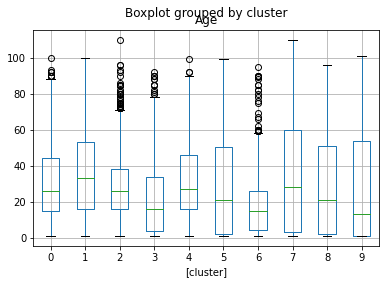

In [15]:
df_info.boxplot(column=['Age'], by=['cluster'])

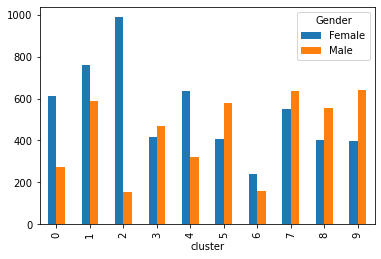

In [16]:
_  = pd.crosstab(df_info['cluster'],df_info['Gender']).plot.bar()

<AxesSubplot:xlabel='cluster'>

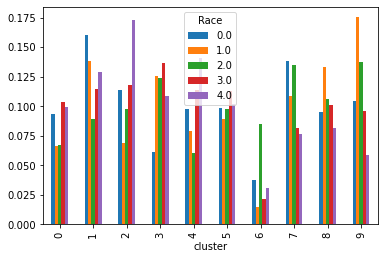

In [17]:
df  = pd.crosstab(df_info['cluster'],df_info['Race'])
df.sum()
df = df/df.sum()
df.plot.bar()

In [18]:
# cluster to visualize
cluster = 4

In [19]:
files = groups[cluster]
if len(files) > 100:
    files = random.sample(files, 100)

faces = pd.DataFrame([])
for path in files:
    img=cv2.imread('crop_part1\\'+path,0)
    face = pd.Series(img.flatten(),name=path)
    faces = faces.append(face)

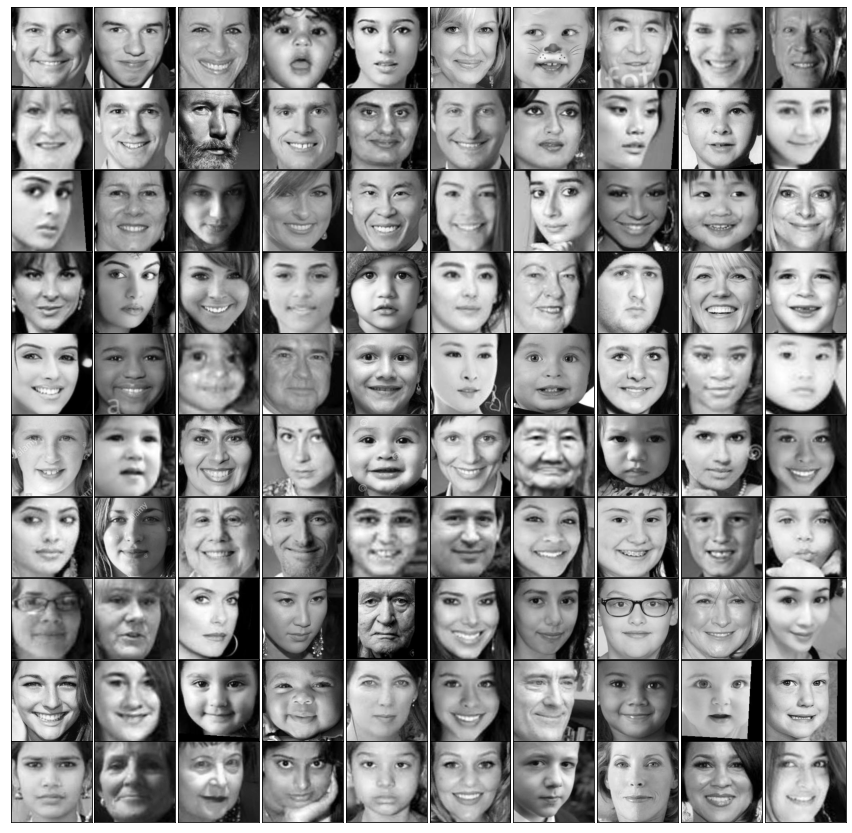

In [20]:
# original images
fig, axes = plt.subplots(10,10,figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(faces.iloc[i]).reshape(200,200),cmap="gray")

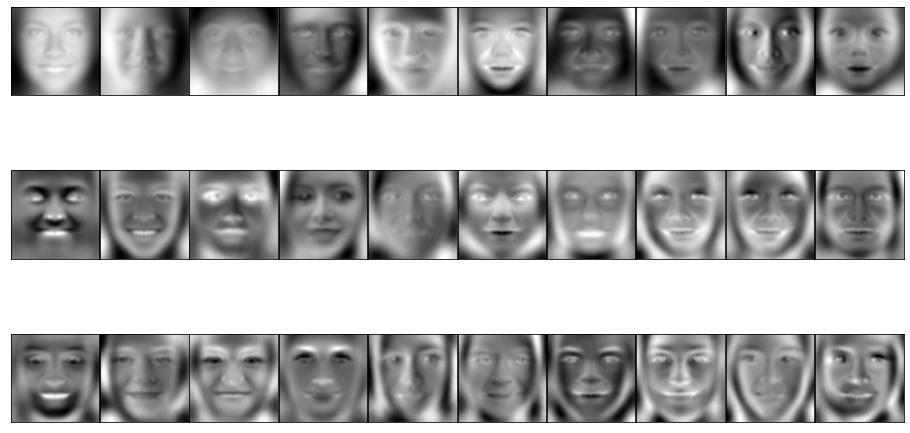

In [21]:
# components
fig, axes = plt.subplots(3,10,figsize=(16,9),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(200,200),cmap="gray")

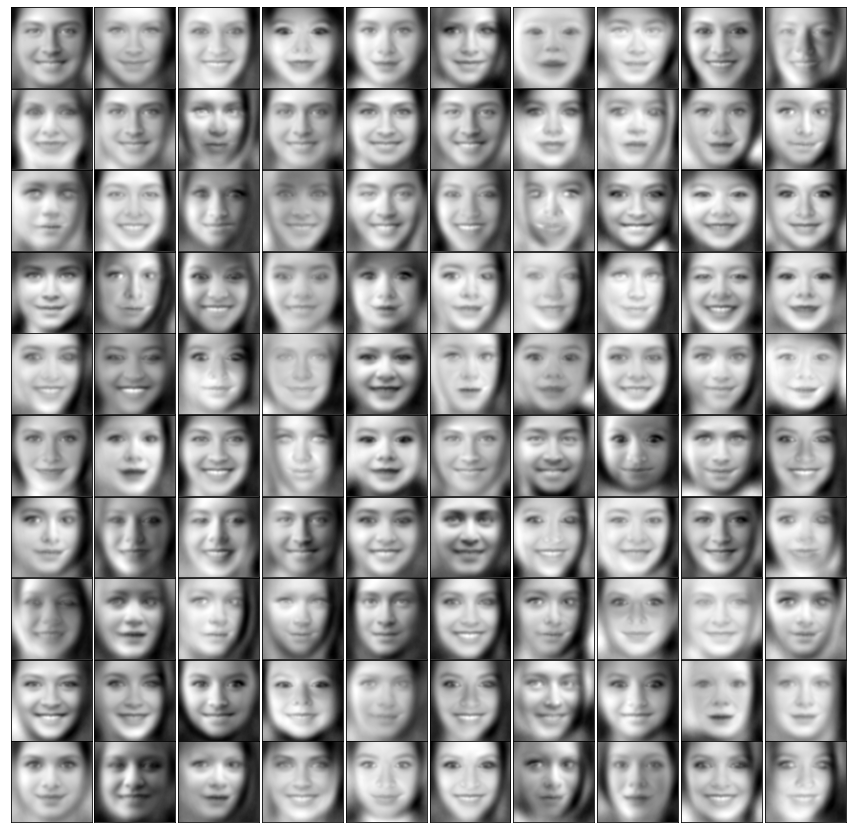

In [22]:
# reconstruct
components = pca.transform(faces)
projected = pca.inverse_transform(components)
fig, axes = plt.subplots(10,10,figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(200,200),cmap="gray")

# ICA

In [23]:
ica = FastICA(n_components=30)
transformed_images_ica = ica.fit_transform(faces_centered)

In [34]:
evs = []
for i in range(100):
    evs.append(explained_variance_score(faces.iloc[i], projected[i]))
print(f'Variance explained by {30} ICA components: {np.mean(evs)}')

Variance explained by 30 ICA components: 0.8500211002751697


In [25]:
kmeans = KMeans(n_clusters=10 ,n_jobs=6, random_state=42)
kmeans.fit(transformed_images_ica)

C:\Users\bgran\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_jobs=6, random_state=42)

In [26]:
groups = {}
for file, cluster in zip(images,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [27]:
df_info=pd.read_csv("ImageInfo.csv")
update_dataframe_with_clusters(groups)

<AxesSubplot:title={'center':'Age'}, xlabel='[cluster]'>

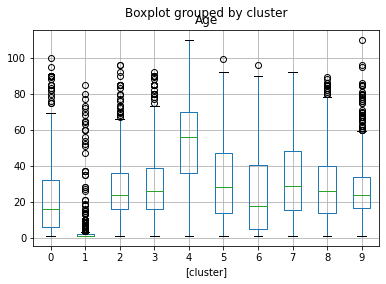

In [28]:
df_info.boxplot(column=['Age'], by=['cluster'])

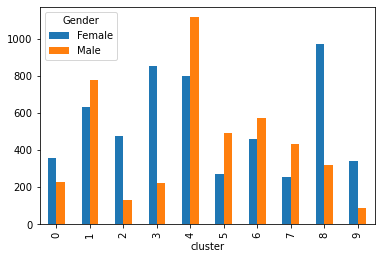

In [29]:
_  = pd.crosstab(df_info['cluster'],df_info['Gender']).plot.bar()

<AxesSubplot:xlabel='cluster'>

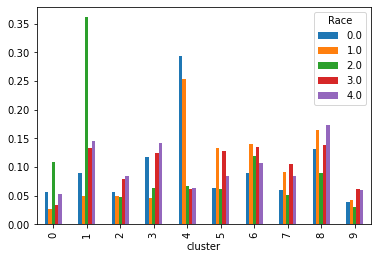

In [30]:
df  = pd.crosstab(df_info['cluster'],df_info['Race'])
df.sum()
df = df/df.sum()
df.plot.bar()

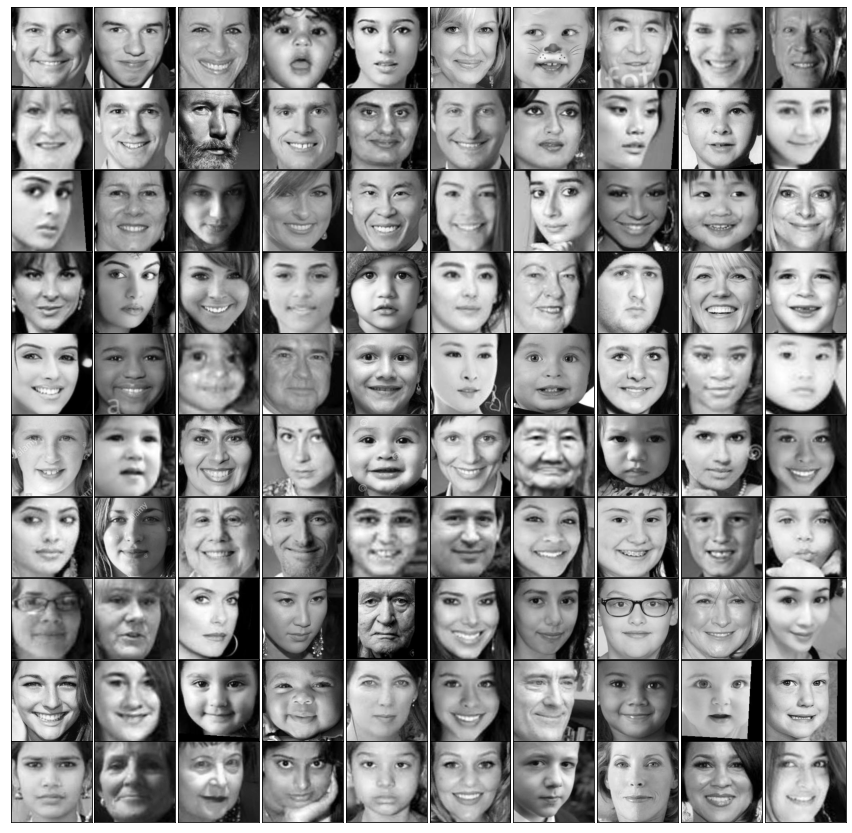

In [31]:
fig, axes = plt.subplots(10,10,figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(faces.iloc[i]).reshape(200,200),cmap="gray")

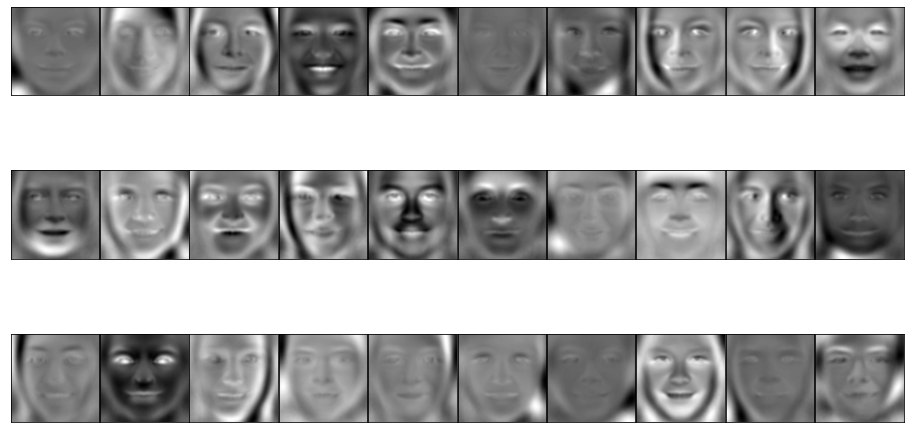

In [32]:
fig, axes = plt.subplots(3,10,figsize=(16,9),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(ica.components_[i].reshape(200,200),cmap="gray")

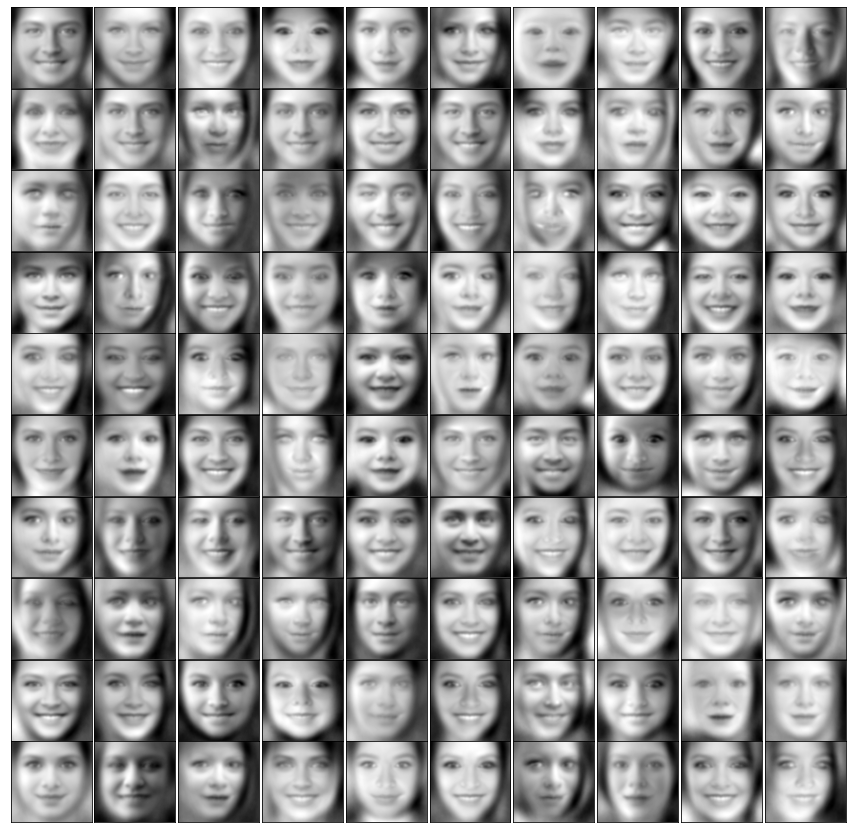

In [33]:
components = ica.transform(faces)
projected = ica.inverse_transform(components)
fig, axes = plt.subplots(10,10,figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(200,200),cmap="gray")